##Project: **Late Delivery Risk Analyzer**




Late shipment risk Analyzer using various Classification models

Team Members -

*   Isabela Matheus
*   Samuel Olugbenga Olusunle Jr
*   Satyam Sharma






Adopting the KDD Methodologies

Step 1: Data Collection

Step 2: Pre-processing and Exploring the data

Step 3: Data Preparation

Step 4: Model Training

Step 5: Evaluating Model Performance

Step 6: Improving Model Performance

##IMPORTANT LIBRARIES AND PACKAGES

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,f1_score,classification_report
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm

#Hiding the warnings
import warnings
warnings.filterwarnings('ignore')

In [42]:
import plotly.express as px

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##|Some Important Functions

In [44]:
#Function to find features with missing values in the dataset
def Missing_Values_Analysis(data):
    #find percentage of missing data
    count_missing_datapoints = data.isnull().sum().sum()
    total_datapoints = data.shape[0]*data.shape[1]
    missing_value_percentage = (count_missing_datapoints/total_datapoints)*100
    print(f"Total missing values in {total_datapoints} datapoints is {count_missing_datapoints} which is {round(missing_value_percentage,2)}% of total data")

    #find features with missing values
    for i in data.columns:
      missing_values = data[i].isna().sum()
      if  missing_values > 0:
        print(f"Feature '{i}' has {missing_values} missing values")

In [45]:
#Function to fill na values
def Fill_Missing_Values(data,cols,custom_value = 0):
  for c in cols:
    data[c] = data[c].fillna(custom_value)

  return data

In [46]:
#Function to format the headers by removing unnecessary spaces and special characters to make the dataset more understandable
def Format_Headers(cols):
    formatted_cols = []
    for col in cols:
        # Strip unnecessary spaces
        col = col.strip()

        # Convert to lowercase
        col = col.lower()

        # Remove special characters using regex
        col = re.sub(r'[^\w\s]', '', col)

        # Replace spaces with underscore
        col = col.replace(" ","_")

        formatted_cols.append(col)

    return formatted_cols


In [47]:
#Function to find duplicate columns in the dataset
def find_duplicate_columns(data):
    duplicate_columns = set()
    for i in range(len(data.columns)):
        for j in range(i + 1, len(data.columns)):
            if data.iloc[:, i].equals(data.iloc[:, j]):
                duplicate_columns.add(data.columns[i])
                duplicate_columns.add(data.columns[j])
                print(f"{data.columns[j]} is a duplicate of column {data.columns[i]}")
    return list(duplicate_columns)

In [48]:
#Function to plot correlation heatmap for all the variables in the dataset
def corr_plot(data):
  corrmap = data.corr()
  top=corrmap.index
  plt.figure(figsize=(30,20))
  g=sns.heatmap(data[top].corr(),annot=True,cmap="RdYlGn")

In [49]:
#Function to perform label encoding to categorical variables
def label_Encoder(data,features):
  le = preprocessing.LabelEncoder()
  for feature in features:
    data[feature] = le.fit_transform(data[feature])

  return data

In [50]:
#Function to apply Classification Models with Hyper-parameter tuning
def Classification_Model(model,X_train, X_test, y_train, y_test,params=0,search_type=""):
  if search_type == "grid":
              clf = GridSearchCV(estimator=model, param_grid=params, scoring=None,
                  n_jobs=-1, cv=5, verbose=0,return_train_score=True)
  elif search_type == "random":
              clf = RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=10,
                  n_jobs=-1,cv=5,verbose=0,random_state=1,return_train_score=True)
  else:
    clf = model
# Fit the model
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  res = []
  res.append(clf)
  res.append(str(clf))

  accuracy_l=accuracy_score(y_pred, y_test) #Accuracy for predection of late delivery
  res.append(round(accuracy_l*100,2))
  recall_l=recall_score(y_pred, y_test)# Recall score for predection of late delivery
  res.append(round(recall_l*100,2))
  conf_l=confusion_matrix(y_test, y_pred)#predection of late delivery
  f1_l=f1_score(y_test, y_pred)#predection of late delivery
  res.append(round(f1_l*100,2))
  print('Model paramters used are :',clf)
  print('Accuracy of late delivery risk analyzer is:', (accuracy_l)*100,'%')
  print('Recall score of late delivery risk analyzer is:', (recall_l)*100,'%')
  print('Conf Matrix of late delivery risk analyzer is: \n',(conf_l))
  print('F1 score of late delivery risk analyzer is:', (f1_l)*100,'%')
  print('Classification Report for late delivery risk analyzer is:\n',classification_report(y_test, y_pred))

  return res

In [51]:
#Function to apply cross validation on Gaussian Naive Bayes Classifier
def GNB_CrossVal(X,y,folds):
  gnb = GaussianNB()
  scores = cross_val_score(gnb, X, y, cv=folds, scoring='accuracy')

  print("Cross-validation scores:", scores)
  print("Mean accuracy:", scores.mean())

In [52]:
#Function to plot feature important graph of the dataset
def Check_Important_Feature(clf,X):
    #Feature importance
  important_col=clf.feature_importances_.argsort()
  feat_imp=pd.DataFrame({'features':X.columns[important_col],'importance':clf.feature_importances_[important_col]})
  feat_imp=feat_imp.sort_values(by='importance',ascending=False)
  ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
  plt.xticks(rotation=90)

###Step 1: **Data Collection**

####Data Source :
Dataset link : https://data.mendeley.com/datasets/8gx2fvg2k6/5

Kaggle dataset link : https://www.kaggle.com/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis


In [53]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DBS/Machine Learning and Pattern Recognition/ML_Project/DataCoSupplyChainDataset.csv",header= 0)

In [54]:
df_fields = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DBS/Machine Learning and Pattern Recognition/ML_Project/DescriptionDataCoSupplyChain.csv")

In [55]:
df_fields

,FIELDS,DESCRIPTION
0,Type,: Type of transaction made
1,Days for shipping (real),: Actual shipping days of the purchased product
2,Days for shipment (scheduled),: Days of scheduled delivery of the purchased...
3,Benefit per order,: Earnings per order placed
4,Sales per customer,: Total sales per customer made per customer
5,Delivery Status,: Delivery status of orders: Advance shipping...
6,Late_delivery_risk,: Categorical variable that indicates if send...
7,Category Id,: Product category code
8,Category Name,: Description of the product category
9,Customer City,: City where the customer made the purchase


In [56]:
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [57]:
df.shape

(180519, 53)

In [58]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


This is the dataset of Supply Chains used by the company DataCo Global which includes a collection of their products sold, finacial details(profit, loss, total sales etc.), Shipping details, and customer details such as sales, demographics, and transaction details.

###Step 2: **Pre-processing and Exploring the data**

Obtain the information about the dataset using info() function

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

Understanding of the data:


1.  There are 53 columns and 180519 rows in this dataset
2.  Product Description field is empty for all the records
3.  Some fields have null values like Order Zipcode, Customer Lname
4.  All the column names are not properly formatted as some name contains parenthesis and spaces



In [60]:
df.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


More understanding about the dataset:

1.   Late delivery risk field is binary (0 or 1) which means that the orders which have Days of shipping (real) greater than the Days of Shipment (scheduled) are marked as 1 and rest are marked as 0.
2.   We can see that the mean of late delivery is more than 0.5 which means that there are more orders that were delivered late compared to on time deliveries. It can be concluded the business is experiencing loss due to late deliveries and need to understand the root cause and develop a predictive model to flag potential late deliveries for future and support better decision making.



####Perform missing values analysis

In [61]:
Missing_Values_Analysis(df)

Total missing values in 9567507 datapoints is 336209 which is 3.51% of total data
Feature 'Customer Lname' has 8 missing values
Feature 'Customer Zipcode' has 3 missing values
Feature 'Order Zipcode' has 155679 missing values
Feature 'Product Description' has 180519 missing values


Analysis:

*   We have observed that there are 4 fields which have missing values namely **Customer Lname (8)**, **Customer Zipcode (3)**, **Order Zipcode (155679)** and **Product Description (180519)**
*   Since Order Zipcode and Product Description are null for more than 50% of the dataset, we can assume that they will not be relevant for the model development and can be dropped from the list of features.
*   Since Customer Last Name  and Customer Zipcode have missing values for less than 0.001% of the data, we can impute the missing values either by using some default values like "NA", 0 or drop the rows with NA value since the percentage of missing data is very less


####Handling Missing Values

#####Handling Product Description and Order Zipcode
Since **Product Description** has all null values and **Order Zipcode** has more than 80% null values we can drop these features as they are not significant for our analysis

In [62]:
df = df.drop(["Product Description","Order Zipcode"],axis=1)
df.shape

(180519, 51)

#####Handling Customer Zipcode
Since only 3 datapoints have missing value for **Customer Zipcode**, we can use fillna function to fill the missing values with 0

In [63]:
df = Fill_Missing_Values(df,["Customer Zipcode"])

In [64]:
df[df['Customer Zipcode'].isna()]

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order State,Order Status,Product Card Id,Product Category Id,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode


#####Handling Customer Lname
since there is a chance different customers might have the same first name or same last name a new column with **customer full name** is created to avoid any ambiguities.

In [65]:
# Adding first name and last name together to create new column
df['Customer Full Name'] = df['Customer Fname'].astype(str)+df['Customer Lname'].astype(str)

#dropping Customer Fname and Lname
df = df.drop(['Customer Fname','Customer Lname'],axis=1)

####Checking for **Duplicates**

In [66]:
df.duplicated().sum()

0

There are no duplicate records present in the dataset

####Formatting Headers

In [67]:
df.columns = Format_Headers(df.columns)
print(df.columns)

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_email', 'customer_id',
       'customer_password', 'customer_segment', 'customer_state',
       'customer_street', 'customer_zipcode', 'department_id',
       'department_name', 'latitude', 'longitude', 'market', 'order_city',
       'order_country', 'order_customer_id', 'order_date_dateorders',
       'order_id', 'order_item_cardprod_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'sales',
       'order_item_total', 'order_profit_per_order', 'order_region',
       'order_state', 'order_status', 'product_card_id', 'product_category_id',
       'product_image', 'product_name', 'product_price', 'product_status',
       's

####Performing Exploratory Data Analysis

Analyze the correlation plot to check the correlation between different attributes

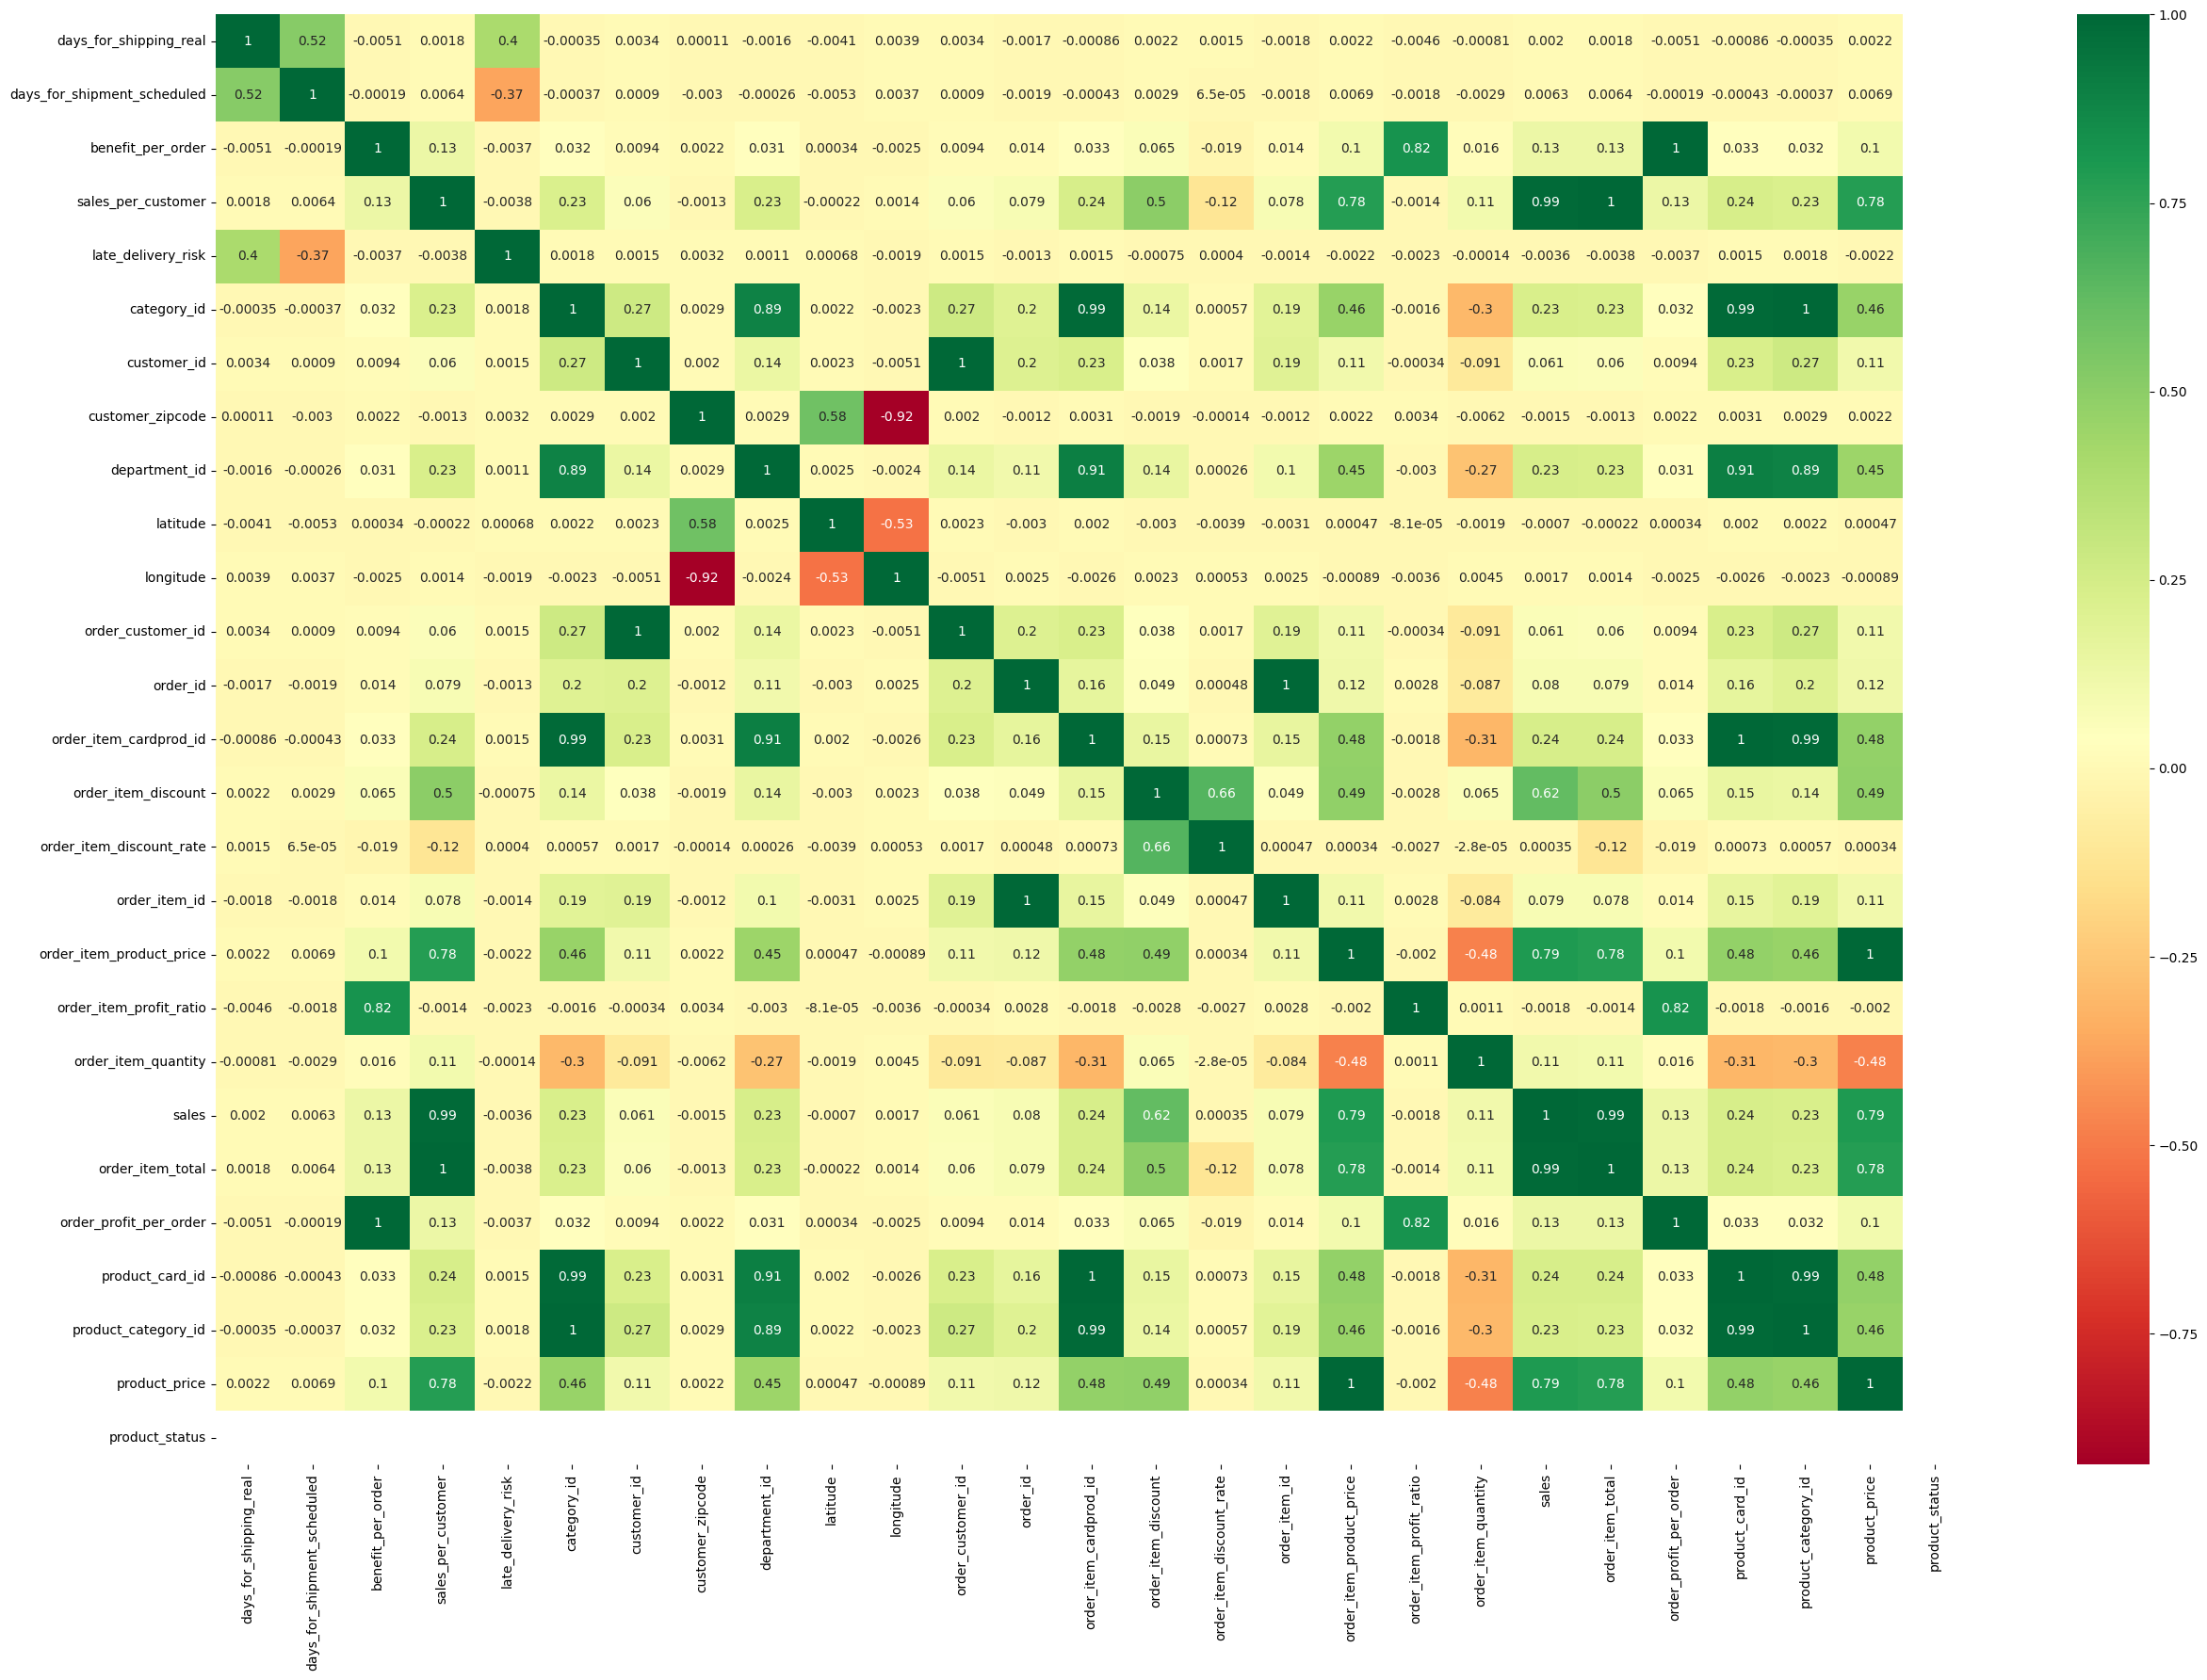

In [68]:
corr_plot(df)

From the above corr plot we can see that there are many columns which have very high correlation and upon further analysis they seems to have duplicate values so it is better to find how many such columns are present in the dataset so that those can be dropped before further analysis

In [69]:
full_dupes = find_duplicate_columns(df)

order_profit_per_order is a duplicate of column benefit_per_order
order_item_total is a duplicate of column sales_per_customer
product_category_id is a duplicate of column category_id
customer_password is a duplicate of column customer_email
order_customer_id is a duplicate of column customer_id
product_card_id is a duplicate of column order_item_cardprod_id
product_price is a duplicate of column order_item_product_price


In [70]:
df[full_dupes]

,order_item_total,customer_email,category_id,order_profit_per_order,product_card_id,product_category_id,order_item_product_price,product_price,customer_id,order_item_cardprod_id,benefit_per_order,customer_password,sales_per_customer,order_customer_id
0,314.640015,XXXXXXXXX,73,91.250000,1360,73,327.750000,327.750000,20755,1360,91.250000,XXXXXXXXX,314.640015,20755
1,311.359985,XXXXXXXXX,73,-249.089996,1360,73,327.750000,327.750000,19492,1360,-249.089996,XXXXXXXXX,311.359985,19492
2,309.720001,XXXXXXXXX,73,-247.779999,1360,73,327.750000,327.750000,19491,1360,-247.779999,XXXXXXXXX,309.720001,19491
3,304.809998,XXXXXXXXX,73,22.860001,1360,73,327.750000,327.750000,19490,1360,22.860001,XXXXXXXXX,304.809998,19490
4,298.250000,XXXXXXXXX,73,134.210007,1360,73,327.750000,327.750000,19489,1360,134.210007,XXXXXXXXX,298.250000,19489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,399.980011,XXXXXXXXX,45,40.000000,1004,45,399.980011,399.980011,1005,1004,40.000000,XXXXXXXXX,399.980011,1005
180515,395.980011,XXXXXXXXX,45,-613.770019,1004,45,399.980011,399.980011,9141,1004,-613.770019,XXXXXXXXX,395.980011,9141
180516,391.980011,XXXXXXXXX,45,141.110001,1004,45,399.980011,399.980011,291,1004,141.110001,XXXXXXXXX,391.980011,291
180517,387.980011,XXXXXXXXX,45,186.229996,1004,45,399.980011,399.980011,2813,1004,186.229996,XXXXXXXXX,387.980011,2813


####Removing duplicate and unwanted attributes

####Dropping duplicated columns

In [71]:
print("Columns before dropping duplicates: ",df.shape[1])

#Dropping duplicate columns
df = df.drop(['order_profit_per_order','order_item_total','order_customer_id','order_item_product_price','order_item_cardprod_id'],axis=1)

print("Columns after dropping duplicates: ",df.shape[1])

Columns before dropping duplicates:  50
Columns after dropping duplicates:  45


####Dropping unwanted attributes like customer password

In [72]:
print("Columns before dropping unwanted attributes: ",df.shape[1])

#Dropping duplicate columns
df = df.drop(['customer_password','customer_email','product_image','product_status'],axis=1)

print("Columns after dropping unwanted attributes: ",df.shape[1])

Columns before dropping unwanted attributes:  45
Columns after dropping unwanted attributes:  41


In [73]:
df.columns

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_id', 'customer_segment', 'customer_state',
       'customer_street', 'customer_zipcode', 'department_id',
       'department_name', 'latitude', 'longitude', 'market', 'order_city',
       'order_country', 'order_date_dateorders', 'order_id',
       'order_item_discount', 'order_item_discount_rate', 'order_item_id',
       'order_item_profit_ratio', 'order_item_quantity', 'sales',
       'order_region', 'order_state', 'order_status', 'product_card_id',
       'product_category_id', 'product_name', 'product_price',
       'shipping_date_dateorders', 'shipping_mode', 'customer_full_name'],
      dtype='object')

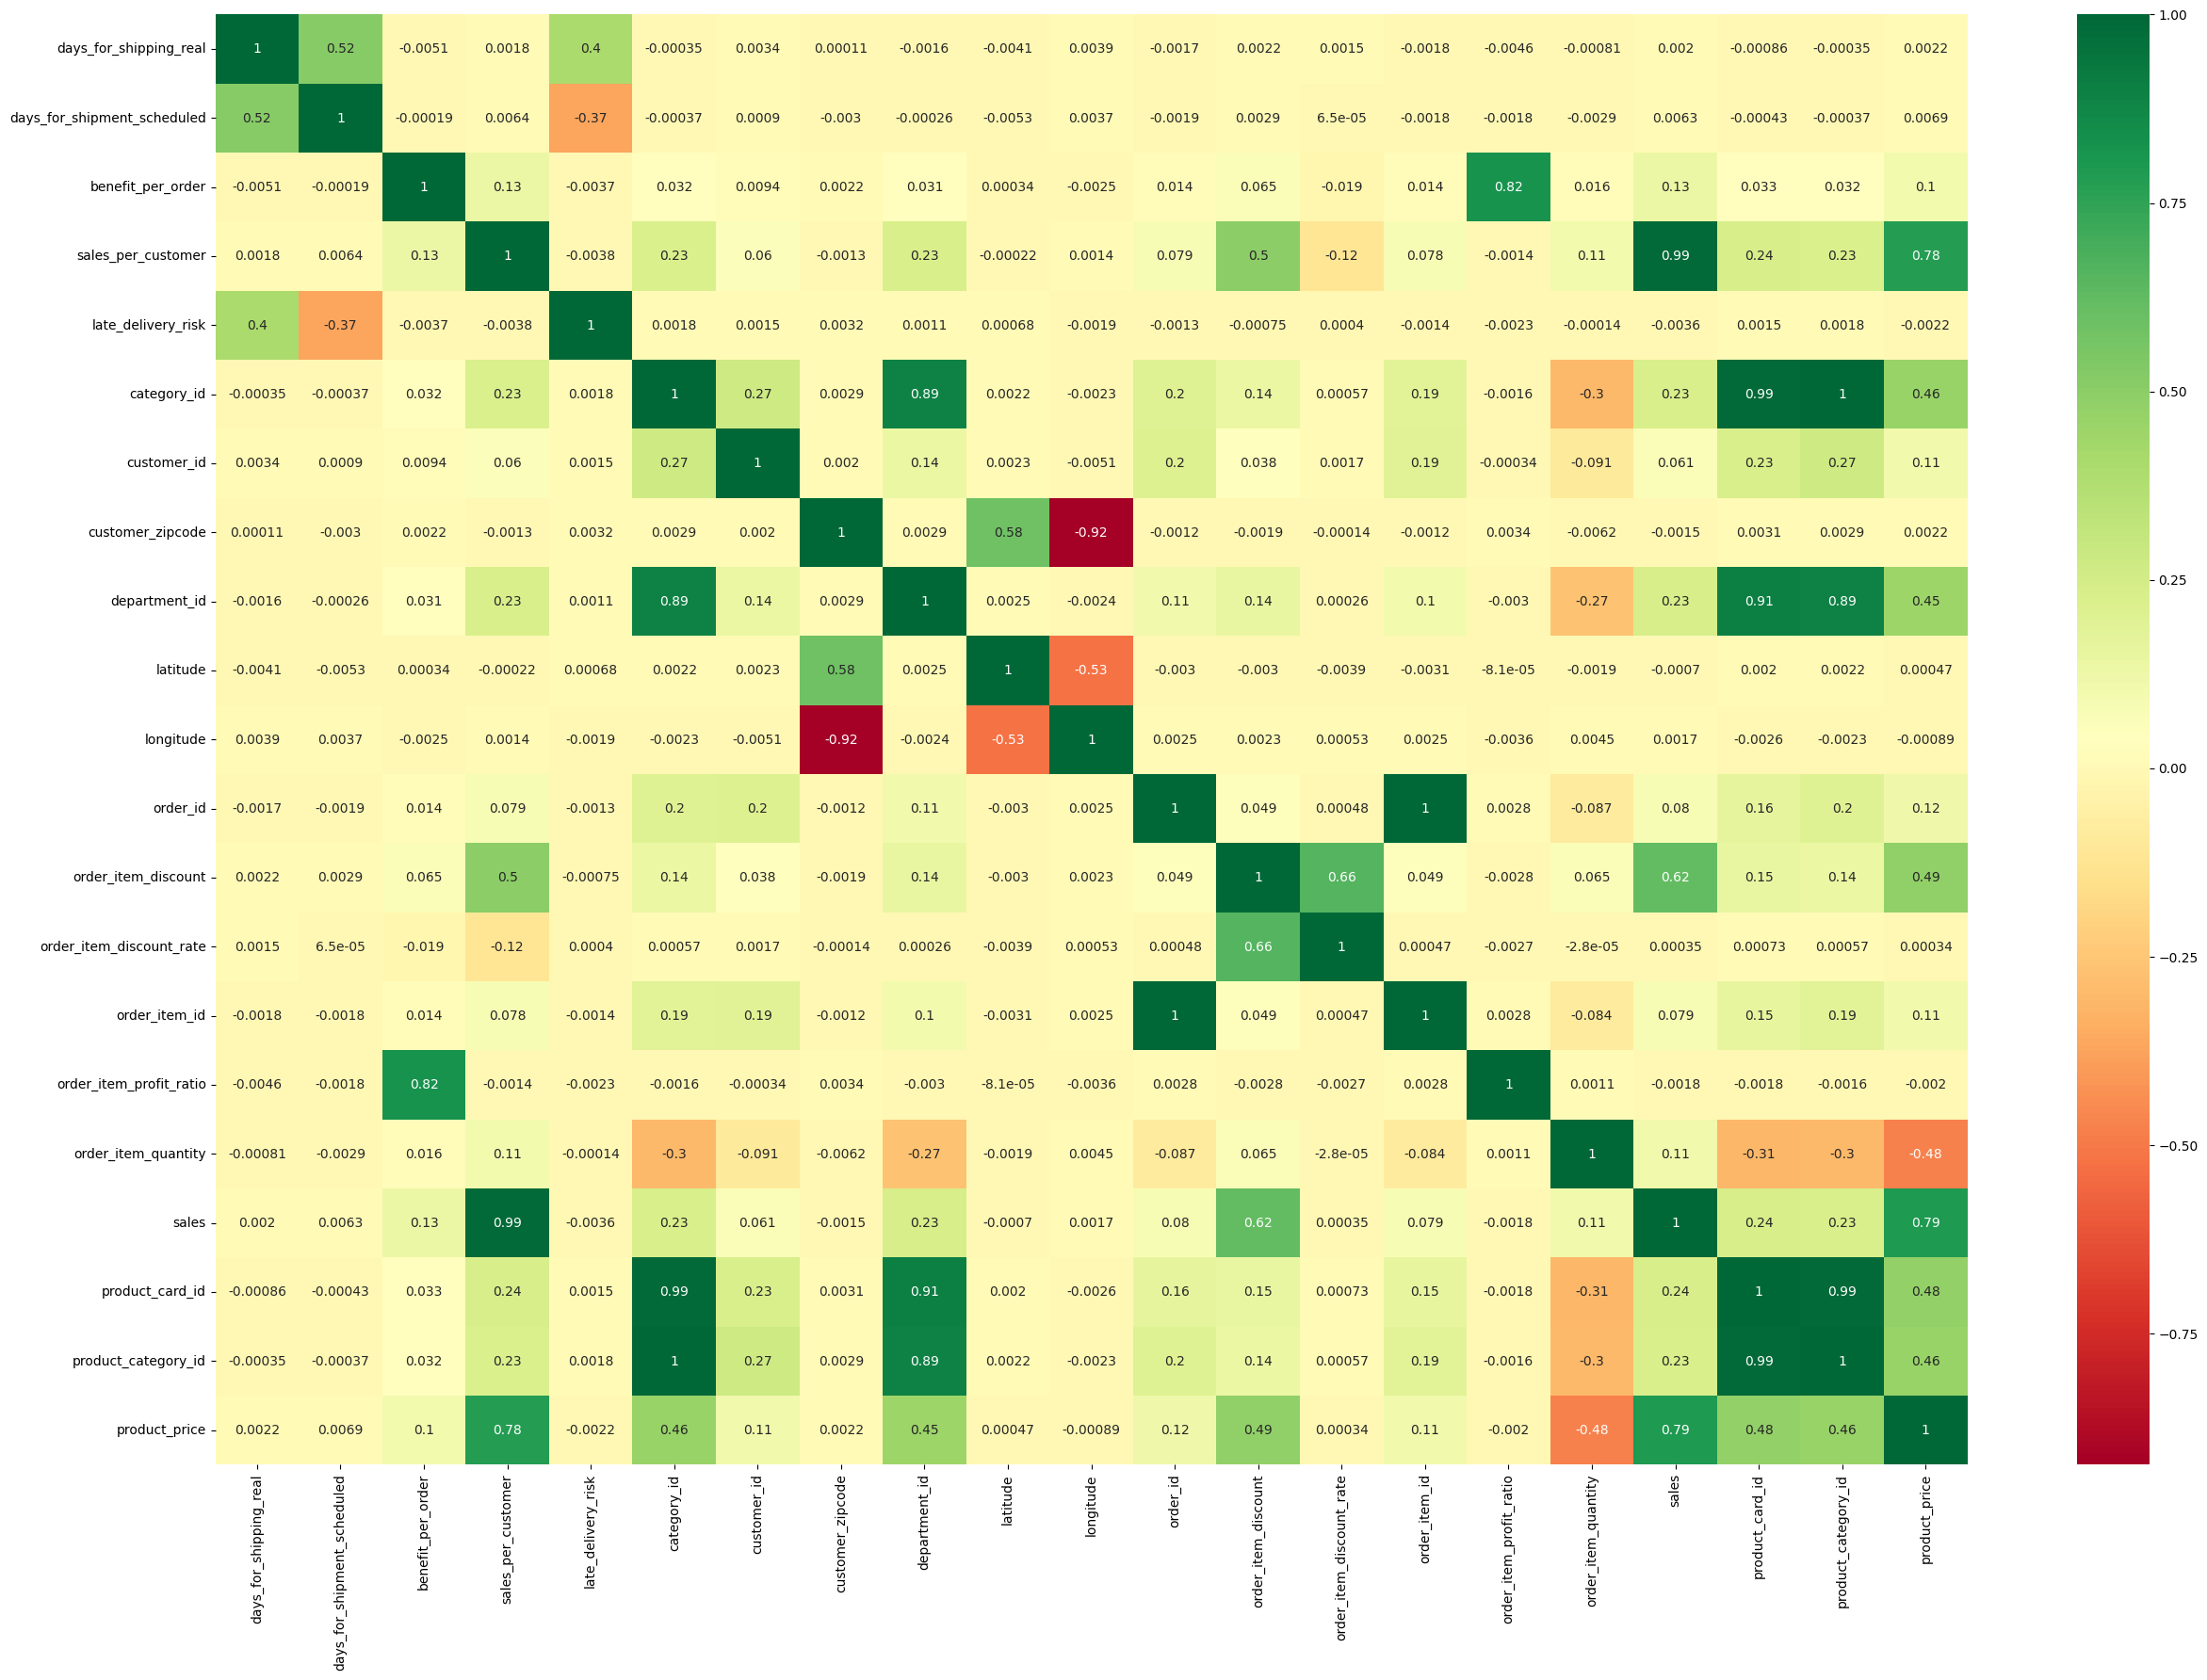

In [74]:
corr_plot(df)

####Plot Delivery Status to visualize late deliveries compared to others

In [75]:
df_ds_plot=df.groupby(['delivery_status'])['order_id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= False)
px.bar(df_ds_plot,title="Number of Orders by Delivery Status", x='delivery_status', y='Number of Orders',color='Number of Orders',text_auto='.2s')

*Inference*: From the plot we can see that there are more than 50% orders with Delivery Status as **Late Delivery**. This make it imperative to develop machine learning models to classify orders with high probability of late deliveries (**Late Delivery Risk Analysis**)

####Delivery Status by Customer Country

In [76]:
df_cc_plot=df.groupby(['delivery_status', 'customer_country'])['order_id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= False)
px.bar(df_cc_plot,title="Delivery Status by Customer Country", x='customer_country', y='Number of Orders'  , color='delivery_status',text_auto='.2s')

####Delivery Status by Market

In [77]:
df_market_plot=df.groupby(['delivery_status', 'market'])['order_id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= False)
px.bar(df_market_plot,title = "Delivery Status by Market", x='market', y='Number of Orders'  , color='delivery_status',text_auto='.2s')

####Check Delivery status by Order Region

In [78]:
df_or_plot=df.groupby(['delivery_status', 'order_region'])['order_id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= False)
px.bar(df_or_plot, x='order_region', y='Number of Orders'  , color='delivery_status')

####Customer Segment with most late deliveries

In [79]:
df_cs = df[df['delivery_status']=='Late delivery']
df_cs_plot=df_cs.groupby(['customer_segment'])['order_id'].count().reset_index(name='Number of Orders with late deliveries').sort_values(by= 'Number of Orders with late deliveries', ascending= False)
px.pie(df_cs_plot, values='Number of Orders with late deliveries', names= 'customer_segment' , title= 'Late deliveries by different Customer Segments',
       width=600 , height=600 , color_discrete_sequence = px.colors.sequential.RdBu)

*Inference*: Consumer segment is the segment with most late deliveries

####Shipment Mode and Delivery Status

In [80]:
df_sm = df.groupby(['shipping_mode','delivery_status'])['order_id'].count().reset_index(name="Number of Orders").sort_values(by="Number of Orders",ascending=False)
px.bar(df_sm,x="shipping_mode",y="Number of Orders",color="delivery_status",text_auto = '.2s')

*Inference*: From above chart we can visualize that **First Class** and **Second Class** have more than 70% of late deliveries while **Standard Class** have most late deliveries in terms of numbers

In [81]:
df_sm_plot=df_cs.groupby(['shipping_mode'])['order_id'].count().reset_index(name='Number of Orders with late deliveries').sort_values(by= 'Number of Orders with late deliveries', ascending= False)
px.pie(df_sm_plot, values='Number of Orders with late deliveries', names= 'shipping_mode' , title= 'Late deliveries by different Shipping Modes',
       width=600 , height=600 , color_discrete_sequence = px.colors.sequential.Rainbow)

*Inference*: From above chart we can see that 41% of the late deliveries are from **Standard Class** but in terms of ratio **First Class** and **Second Class** have very high late deliveries

###Step 3: Data Preparation and Feature Engineering

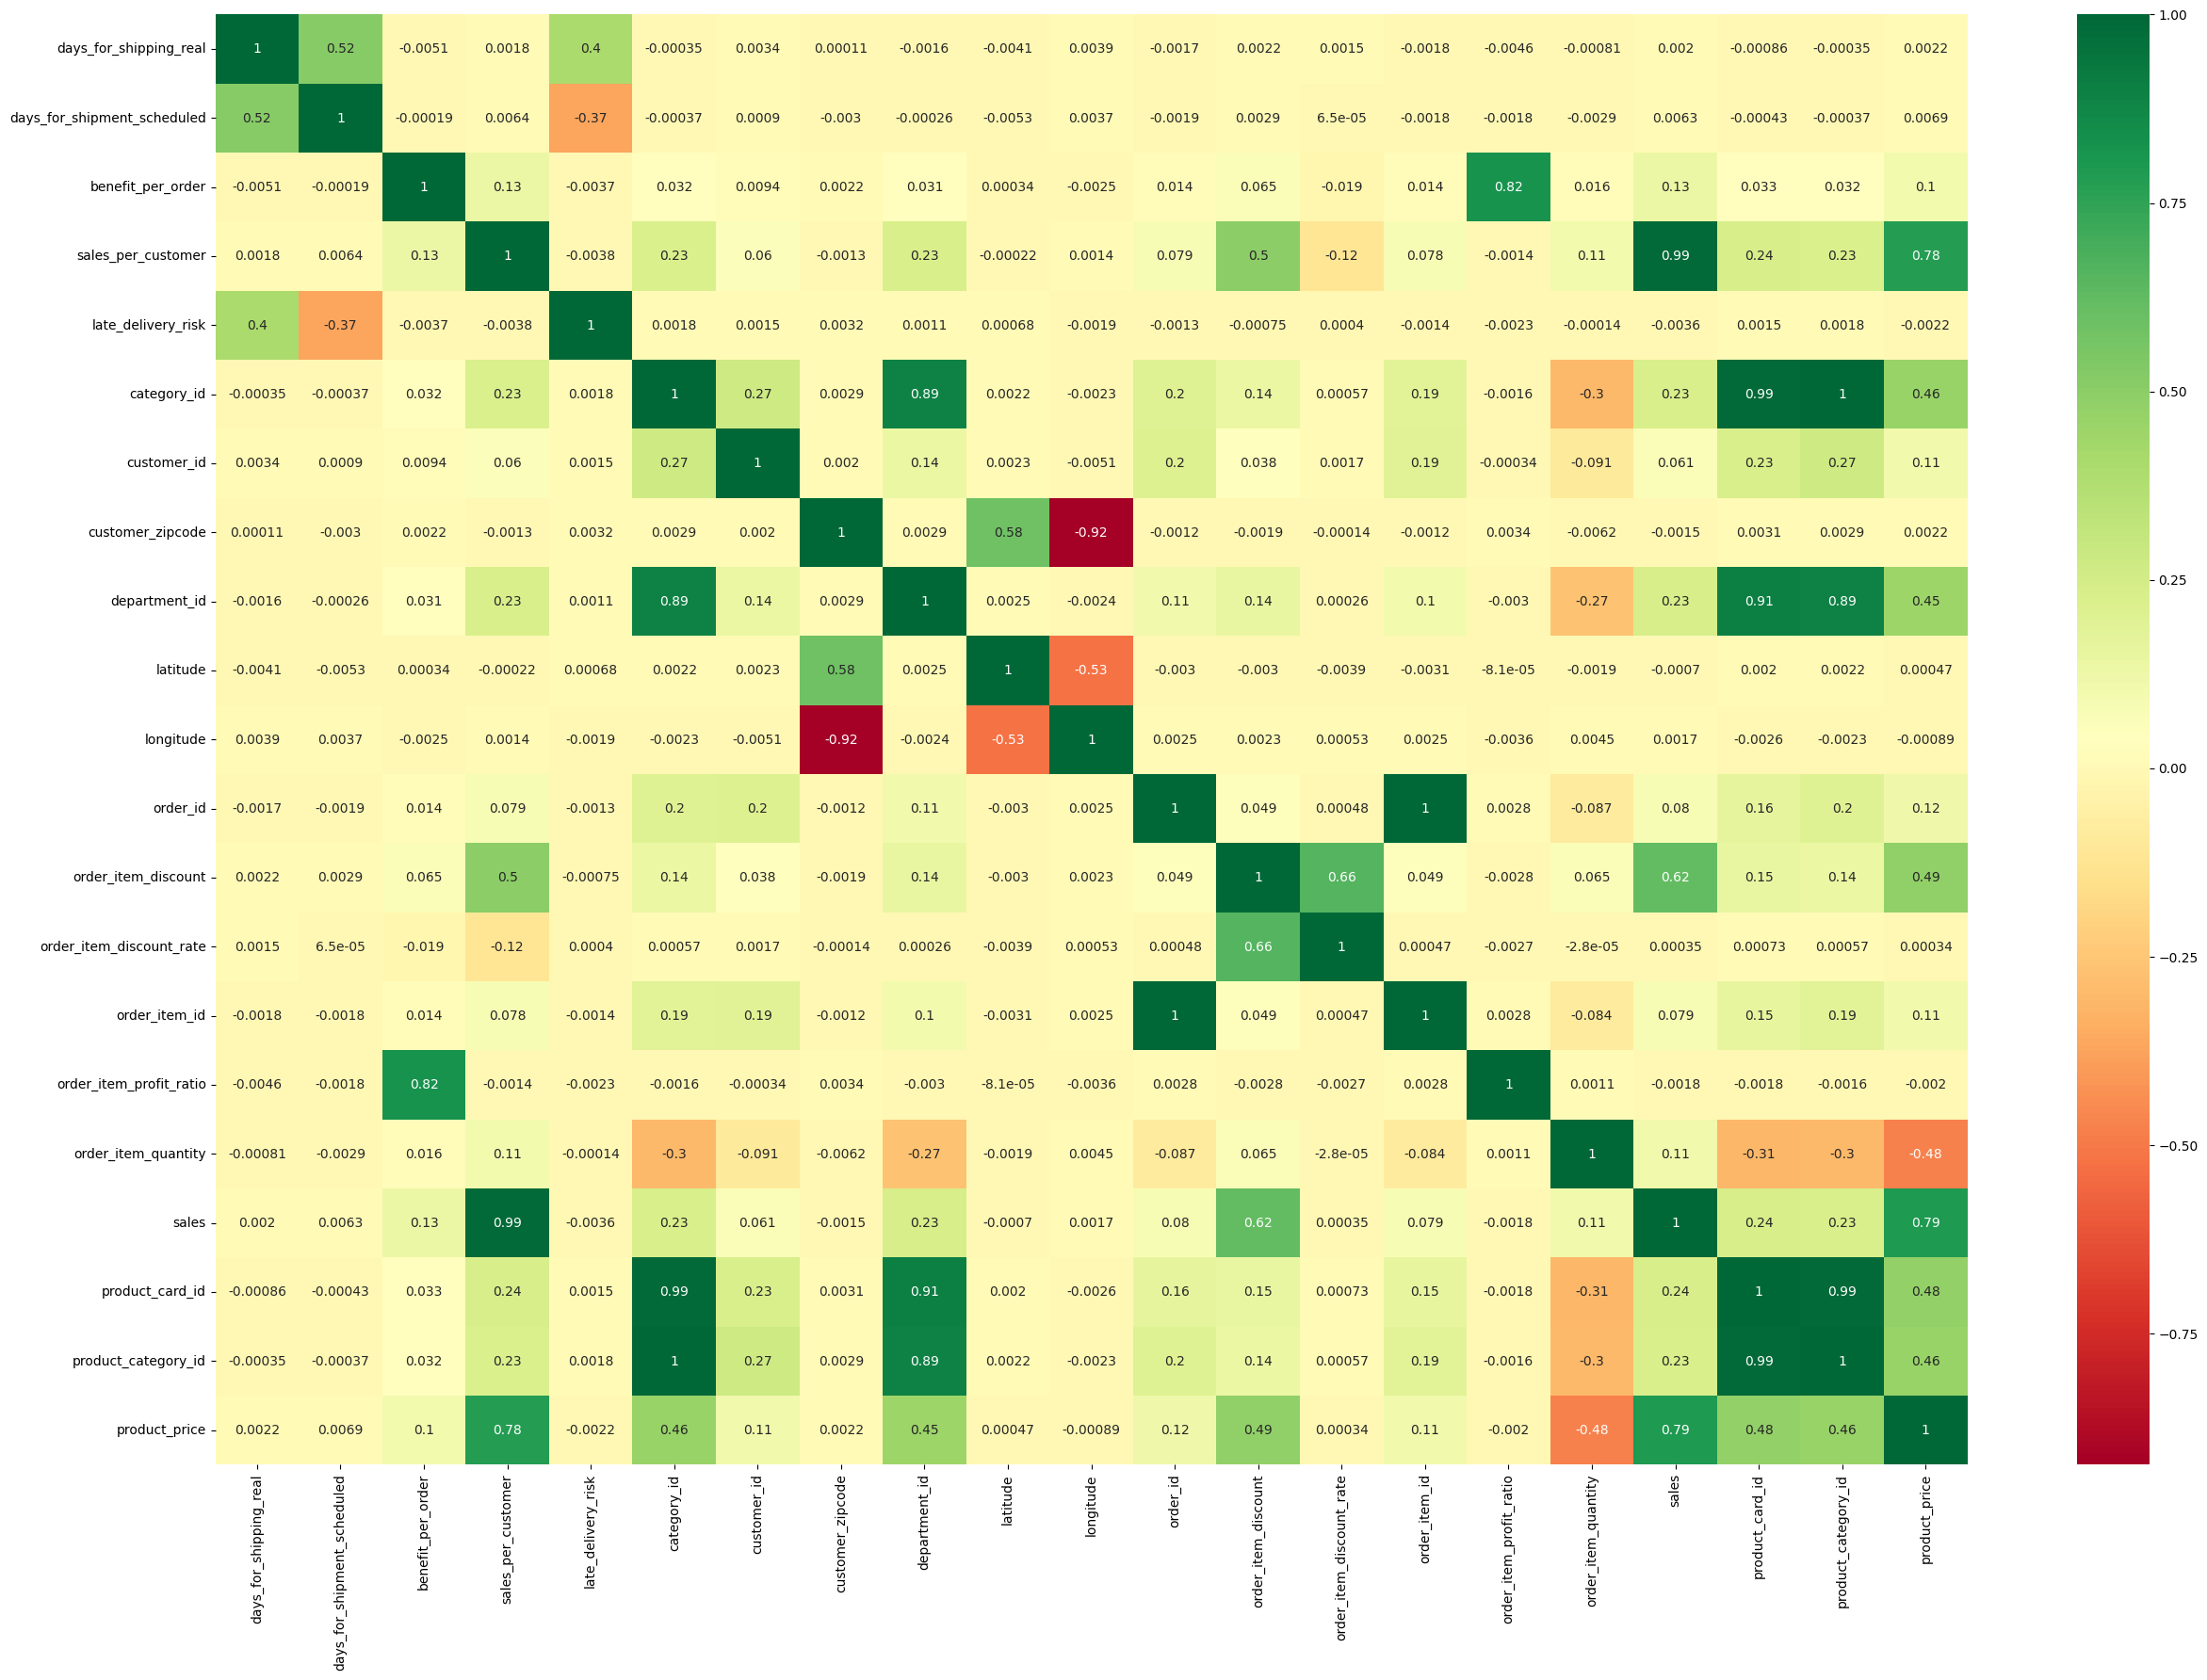

In [82]:
corr_plot(df)

####Datatype Conversions
In the given dataset date variables are set to object type. We can convert date type variables into day, month, year level features for better result

In [83]:
# Convert to datetime
df['order_date_dateorders'] = pd.to_datetime(df['order_date_dateorders'])
df['shipping_date_dateorders'] = pd.to_datetime(df['shipping_date_dateorders'])

# Extract day, month, and year features
df['order_day'] = df['order_date_dateorders'].dt.day
df['order_month'] = df['order_date_dateorders'].dt.month
df['order_year'] = df['order_date_dateorders'].dt.year

df['shipping_day'] = df['shipping_date_dateorders'].dt.day
df['shipping_month'] = df['shipping_date_dateorders'].dt.month
df['shipping_year'] = df['shipping_date_dateorders'].dt.year

# Drop the original datetime columns
df.drop(['order_date_dateorders', 'shipping_date_dateorders'], axis=1, inplace=True)


In [84]:
df.columns

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_id', 'customer_segment', 'customer_state',
       'customer_street', 'customer_zipcode', 'department_id',
       'department_name', 'latitude', 'longitude', 'market', 'order_city',
       'order_country', 'order_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_profit_ratio',
       'order_item_quantity', 'sales', 'order_region', 'order_state',
       'order_status', 'product_card_id', 'product_category_id',
       'product_name', 'product_price', 'shipping_mode', 'customer_full_name',
       'order_day', 'order_month', 'order_year', 'shipping_day',
       'shipping_month', 'shipping_year'],
      dtype='object')

In [85]:
# Feature engineering
df['days_difference'] = (df['days_for_shipping_real'] - df['days_for_shipment_scheduled']).abs()

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   type                         180519 non-null  object 
 1   days_for_shipping_real       180519 non-null  int64  
 2   days_for_shipment_scheduled  180519 non-null  int64  
 3   benefit_per_order            180519 non-null  float64
 4   sales_per_customer           180519 non-null  float64
 5   delivery_status              180519 non-null  object 
 6   late_delivery_risk           180519 non-null  int64  
 7   category_id                  180519 non-null  int64  
 8   category_name                180519 non-null  object 
 9   customer_city                180519 non-null  object 
 10  customer_country             180519 non-null  object 
 11  customer_id                  180519 non-null  int64  
 12  customer_segment             180519 non-null  object 
 13 

We can drop some features which will not directly contribute to the final classification model of late delivery risk. Some of these features can be order_id, product_card_id,etc

In [87]:
df_final_features = df.drop(['product_category_id','order_id','order_item_id','department_id','customer_id','category_id','product_card_id','days_for_shipping_real','customer_full_name','product_name','category_name','shipping_day','shipping_month','shipping_year','customer_street','delivery_status'],axis=1)

In [88]:
df_final_features.shape[1]

30

####Apply Label Encoding to categorical features

In [89]:
df_final_features = label_Encoder(df_final_features,df_final_features.select_dtypes(include=['object']).columns.tolist())

In [90]:
df_final_features.shape

(180519, 30)

In [91]:
df_final_features.head()

,type,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,late_delivery_risk,customer_city,customer_country,customer_segment,customer_state,customer_zipcode,...,sales,order_region,order_state,order_status,product_price,shipping_mode,order_day,order_month,order_year,days_difference
0,1,4,91.250000,314.640015,0,66,1,0,36,725.0,...,327.75,15,475,2,327.75,3,31,1,2018,1
1,3,4,-249.089996,311.359985,1,66,1,0,36,725.0,...,327.75,13,841,5,327.75,3,13,1,2018,1
2,0,4,-247.779999,309.720001,0,452,0,0,5,95125.0,...,327.75,13,841,1,327.75,3,13,1,2018,0
3,1,4,22.860001,304.809998,0,285,0,2,5,90027.0,...,327.75,11,835,2,327.75,3,13,1,2018,1
4,2,4,134.210007,298.250000,0,66,1,1,36,725.0,...,327.75,11,835,6,327.75,3,13,1,2018,2


###Model Development and Training

####Defining Dependent Features and Problem type

Dependent Feature: late_delivery_risk

Problem Type: Classification


In [92]:
X = df_final_features.drop(['late_delivery_risk'],axis=1)
y = df_final_features['late_delivery_risk']

####Create Train and Test Data

In [93]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=42)

In [94]:
result = [[]]

###Logistic Regression

####Apply Logistic Regression on non-scaled data

In [95]:
lr = LogisticRegression()
lr_clf = Classification_Model(lr,X_train,X_test,y_train,y_test)
result.append(lr_clf)

Model paramters used are : LogisticRegression()
Accuracy of late delivery risk analyzer is: 55.118546421449146 %
Recall score of late delivery risk analyzer is: 55.56760777264698 %
Conf Matrix of late delivery risk analyzer is: 
 [[ 1970 14337]
 [ 1867 17930]]
F1 score of late delivery risk analyzer is: 68.87676705593117 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.51      0.12      0.20     16307
           1       0.56      0.91      0.69     19797

    accuracy                           0.55     36104
   macro avg       0.53      0.51      0.44     36104
weighted avg       0.54      0.55      0.47     36104



####Logistic Regression with GridSearchCV optimizer

In [96]:
# Logistic Regression
# GridSearch CV params
lr_grid = {}
lr_grid["C"] =  [0.01, 0.1, 10, 100]
lr_grid["fit_intercept"] =  [True, False]
lr_grid["warm_start"] = [True,False]
lr_grid["random_state"] = [1]

#Logistic Regression with GridSearch CV
lr_clf_grid=Classification_Model(lr,X_train,X_test,y_train,y_test,lr_grid,"grid")
result.append(lr_clf_grid)

Model paramters used are : GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 10, 100],
                         'fit_intercept': [True, False], 'random_state': [1],
                         'warm_start': [True, False]},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 56.971526700642585 %
Recall score of late delivery risk analyzer is: 57.82420326039066 %
Conf Matrix of late delivery risk analyzer is: 
 [[ 4820 11487]
 [ 4048 15749]]
F1 score of late delivery risk analyzer is: 66.96999978738333 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.54      0.30      0.38     16307
           1       0.58      0.80      0.67     19797

    accuracy                           0.57     36104
   macro avg       0.56      0.55      0.53     36104
weighted avg       0.56      0.57      0.54     36104



####Logistic Regression with RandomSearchCV optimizer

In [98]:
# Random SearchCV params
lr_random = {}
lr_random["C"] = [0.01, 0.1, 10, 100]
lr_random["fit_intercept"] =  [True, False]
lr_random["warm_start"] = [True,False]
lr_random["random_state"] = [1]

#Logistic Regression with RandomSearch CV
lr_clf_random = Classification_Model(lr,X_train,X_test,y_train,y_test,lr_random,"random")
result.append(lr_clf_random)

Model paramters used are : RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'random_state': [1],
                                        'warm_start': [True, False]},
                   random_state=1, return_train_score=True)
Accuracy of late delivery risk analyzer is: 56.971526700642585 %
Recall score of late delivery risk analyzer is: 57.82420326039066 %
Conf Matrix of late delivery risk analyzer is: 
 [[ 4820 11487]
 [ 4048 15749]]
F1 score of late delivery risk analyzer is: 66.96999978738333 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.54      0.30      0.38     16307
           1       0.58      0.80      0.67     19797

    accuracy                           0.57     36104
   macro avg       0.

####Perform standard and min-max scaling

In [99]:
ss = StandardScaler()
X_ss = ss.fit_transform(X)

mm = MinMaxScaler()
X_mm = mm.fit_transform(X)

In [100]:
X_train_ss,X_test_ss,y_train_ss,y_test_ss = model_selection.train_test_split(X_ss,y,test_size=0.2,random_state=42)
X_train_mm,X_test_mm,y_train_mm,y_test_mm = model_selection.train_test_split(X_mm,y,test_size=0.2,random_state=42)

####Apply Logistic Regression on standard scaled data

In [101]:
lr_ss_clf = Classification_Model(lr,X_train_ss,X_test_ss,y_train_ss,y_test_ss)
result.append(lr_ss_clf)

Model paramters used are : LogisticRegression()
Accuracy of late delivery risk analyzer is: 74.030578329271 %
Recall score of late delivery risk analyzer is: 76.04078164825829 %
Conf Matrix of late delivery risk analyzer is: 
 [[11513  4794]
 [ 4582 15215]]
F1 score of late delivery risk analyzer is: 76.44576194543536 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71     16307
           1       0.76      0.77      0.76     19797

    accuracy                           0.74     36104
   macro avg       0.74      0.74      0.74     36104
weighted avg       0.74      0.74      0.74     36104



####Apply Logistic Regression on standard scaled data with gridsearchCV optimizer

In [102]:
lr_ss_clf_grid = Classification_Model(lr,X_train_ss,X_test_ss,y_train_ss,y_test_ss,lr_grid,"grid")
result.append(lr_ss_clf_grid)

Model paramters used are : GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 10, 100],
                         'fit_intercept': [True, False], 'random_state': [1],
                         'warm_start': [True, False]},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 74.030578329271 %
Recall score of late delivery risk analyzer is: 76.02517356775385 %
Conf Matrix of late delivery risk analyzer is: 
 [[11507  4800]
 [ 4576 15221]]
F1 score of late delivery risk analyzer is: 76.45286051534482 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71     16307
           1       0.76      0.77      0.76     19797

    accuracy                           0.74     36104
   macro avg       0.74      0.74      0.74     36104
weighted avg       0.74      0.74      0.74     36104



####Apply Logistic Regression on standard scaled data with randomsearchCV optimizer

In [103]:
lr_ss_clf_random = Classification_Model(lr,X_train_ss,X_test_ss,y_train_ss,y_test_ss,lr_random,"random")
result.append(lr_ss_clf_random)

Model paramters used are : RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'random_state': [1],
                                        'warm_start': [True, False]},
                   random_state=1, return_train_score=True)
Accuracy of late delivery risk analyzer is: 74.030578329271 %
Recall score of late delivery risk analyzer is: 76.02517356775385 %
Conf Matrix of late delivery risk analyzer is: 
 [[11507  4800]
 [ 4576 15221]]
F1 score of late delivery risk analyzer is: 76.45286051534482 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71     16307
           1       0.76      0.77      0.76     19797

    accuracy                           0.74     36104
   macro avg       0.74 

####Apply Logistic Regression on min-max scaled data

In [104]:
lr_mm_clf = Classification_Model(lr,X_train_mm,X_test_mm,y_train_mm,y_test_mm)
result.append(lr_mm_clf)

Model paramters used are : LogisticRegression()
Accuracy of late delivery risk analyzer is: 74.03334810547307 %
Recall score of late delivery risk analyzer is: 76.02897102897103 %
Conf Matrix of late delivery risk analyzer is: 
 [[11508  4799]
 [ 4576 15221]]
F1 score of late delivery risk analyzer is: 76.45478062134265 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71     16307
           1       0.76      0.77      0.76     19797

    accuracy                           0.74     36104
   macro avg       0.74      0.74      0.74     36104
weighted avg       0.74      0.74      0.74     36104



####Apply Logistic Regression on min-max scaled data with gridsearchCV optimizer

In [105]:
lr_mm_clf_grid = Classification_Model(lr,X_train_mm,X_test_mm,y_train_mm,y_test_mm,lr_grid,"grid")
result.append(lr_mm_clf_grid)

Model paramters used are : GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 10, 100],
                         'fit_intercept': [True, False], 'random_state': [1],
                         'warm_start': [True, False]},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 74.02503877686682 %
Recall score of late delivery risk analyzer is: 76.0305801229201 %
Conf Matrix of late delivery risk analyzer is: 
 [[11510  4797]
 [ 4581 15216]]
F1 score of late delivery risk analyzer is: 76.44310474755086 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71     16307
           1       0.76      0.77      0.76     19797

    accuracy                           0.74     36104
   macro avg       0.74      0.74      0.74     36104
weighted avg       0.74      0.74      0.74     36104



####Apply Logistic Regression on min-max scaled data with randomsearchCV optimizer

In [106]:
lr_mm_clf_random = Classification_Model(lr,X_train_mm,X_test_mm,y_train_mm,y_test_mm,lr_random,"random")
result.append(lr_mm_clf_random)

Model paramters used are : RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'random_state': [1],
                                        'warm_start': [True, False]},
                   random_state=1, return_train_score=True)
Accuracy of late delivery risk analyzer is: 74.02780855306891 %
Recall score of late delivery risk analyzer is: 76.02917665867307 %
Conf Matrix of late delivery risk analyzer is: 
 [[11509  4798]
 [ 4579 15218]]
F1 score of late delivery risk analyzer is: 76.44739155552207 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71     16307
           1       0.76      0.77      0.76     19797

    accuracy                           0.74     36104
   macro avg       0.7

###Gaussian Naive Bayes Classifier

####Apply Gaussian Naive Bayes on non-scaled data

In [107]:
gnb = GaussianNB()
gnb_clf = Classification_Model(gnb,X_train,X_test,y_train,y_test)
result.append(gnb_clf)

Model paramters used are : GaussianNB()
Accuracy of late delivery risk analyzer is: 70.57112785286948 %
Recall score of late delivery risk analyzer is: 82.96434732604946 %
Conf Matrix of late delivery risk analyzer is: 
 [[13937  2370]
 [ 8255 11542]]
F1 score of late delivery risk analyzer is: 68.48022783232966 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.63      0.85      0.72     16307
           1       0.83      0.58      0.68     19797

    accuracy                           0.71     36104
   macro avg       0.73      0.72      0.70     36104
weighted avg       0.74      0.71      0.70     36104



####Apply GaussianNB on non-scaled data with gridsearchCV optimizer

In [108]:
# Gaussian Naive Bayes
# GridSearch CV params
gnb_grid = {}
gnb_grid["var_smoothing"] =  [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]


#GaussianNB with GridSearch CV
gnb_clf_grid = Classification_Model(gnb,X_train,X_test,y_train,y_test,gnb_grid,"grid")
result.append(gnb_clf_grid)

Model paramters used are : GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                           1e-07, 1e-08, 1e-09, 1e-10, 1e-11,
                                           1e-12, 1e-13, 1e-14, 1e-15]},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 72.67338799025039 %
Recall score of late delivery risk analyzer is: 87.85545475337348 %
Conf Matrix of late delivery risk analyzer is: 
 [[14714  1593]
 [ 8273 11524]]
F1 score of late delivery risk analyzer is: 70.02491341070667 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75     16307
           1       0.88      0.58      0.70     19797

    accuracy                           0.73     36104
   macro avg       0.76      0.74      0.72     36104
weighted avg       0.77      0.73      0.72  

####Apply Gaussian Naive Bayes on standard scaled data

In [109]:
gnb_ss_clf = Classification_Model(gnb,X_train_ss,X_test_ss,y_train_ss,y_test_ss)
result.append(gnb_ss_clf)

Model paramters used are : GaussianNB()
Accuracy of late delivery risk analyzer is: 72.6706182140483 %
Recall score of late delivery risk analyzer is: 87.84298780487805 %
Conf Matrix of late delivery risk analyzer is: 
 [[14712  1595]
 [ 8272 11525]]
F1 score of late delivery risk analyzer is: 70.02460734574841 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75     16307
           1       0.88      0.58      0.70     19797

    accuracy                           0.73     36104
   macro avg       0.76      0.74      0.72     36104
weighted avg       0.77      0.73      0.72     36104



####Apply Gaussian Naive Bayes on standard scaled data with gridsearchCV optimizer

In [110]:
gnb_ss_clf_grid = Classification_Model(gnb,X_train_ss,X_test_ss,y_train_ss,y_test_ss,gnb_grid,'grid')
result.append(gnb_ss_clf_grid)

Model paramters used are : GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                           1e-07, 1e-08, 1e-09, 1e-10, 1e-11,
                                           1e-12, 1e-13, 1e-14, 1e-15]},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 72.6706182140483 %
Recall score of late delivery risk analyzer is: 87.84298780487805 %
Conf Matrix of late delivery risk analyzer is: 
 [[14712  1595]
 [ 8272 11525]]
F1 score of late delivery risk analyzer is: 70.02460734574841 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75     16307
           1       0.88      0.58      0.70     19797

    accuracy                           0.73     36104
   macro avg       0.76      0.74      0.72     36104
weighted avg       0.77      0.73      0.72   

####Apply Gaussian Naive Bayes on min-max scaled data

In [111]:
gnb_mm_clf = Classification_Model(gnb,X_train_mm,X_test_mm,y_train_mm,y_test_mm)
result.append(gnb_mm_clf)

Model paramters used are : GaussianNB()
Accuracy of late delivery risk analyzer is: 72.6706182140483 %
Recall score of late delivery risk analyzer is: 87.84298780487805 %
Conf Matrix of late delivery risk analyzer is: 
 [[14712  1595]
 [ 8272 11525]]
F1 score of late delivery risk analyzer is: 70.02460734574841 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75     16307
           1       0.88      0.58      0.70     19797

    accuracy                           0.73     36104
   macro avg       0.76      0.74      0.72     36104
weighted avg       0.77      0.73      0.72     36104



####Apply Gaussian Naive Bayes on min-max scaled data with gridsearchCV optimizer

In [112]:
gnb_mm_clf_grid = Classification_Model(gnb,X_train_mm,X_test_mm,y_train_mm,y_test_mm,gnb_grid,'grid')
result.append(gnb_mm_clf_grid)

Model paramters used are : GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                           1e-07, 1e-08, 1e-09, 1e-10, 1e-11,
                                           1e-12, 1e-13, 1e-14, 1e-15]},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 72.73709284289829 %
Recall score of late delivery risk analyzer is: 88.07374541003672 %
Conf Matrix of late delivery risk analyzer is: 
 [[14748  1559]
 [ 8284 11513]]
F1 score of late delivery risk analyzer is: 70.05385013234353 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75     16307
           1       0.88      0.58      0.70     19797

    accuracy                           0.73     36104
   macro avg       0.76      0.74      0.73     36104
weighted avg       0.77      0.73      0.72  

###K-fold Cross-Validation

In [113]:
GNB_CrossVal(X_ss,y,5)

Cross-validation scores: [0.74795037 0.75794926 0.71895081 0.70166741 0.70365344]
Mean accuracy: 0.726034254672258


*Inference*: Even after application of cross validation the model is able to generate the same result, we can conclude that the model is not showing overfitting behavior

###Support Vector Classifier

####Apply Support Vector Classifer on non-scaled data

In [114]:
X_train_svc,X_test_svc,y_train_svc,y_test_svc = model_selection.train_test_split(X_ss,y,train_size=0.5,random_state=42)
svc = svm.SVC()
start = time.time()
svc_ss_clf = Classification_Model(svc,X_train_svc, X_test_svc, y_train_svc, y_test_svc)
result.append(svc_ss_clf)
print("Total execution time for Support Vector Machine model was: ", time.time()-start)

Model paramters used are : SVC()
Accuracy of late delivery risk analyzer is: 77.81963217372036 %
Recall score of late delivery risk analyzer is: 82.73175913426428 %
Conf Matrix of late delivery risk analyzer is: 
 [[32856  7803]
 [12217 37384]]
F1 score of late delivery risk analyzer is: 78.87918301894753 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.73      0.81      0.77     40659
           1       0.83      0.75      0.79     49601

    accuracy                           0.78     90260
   macro avg       0.78      0.78      0.78     90260
weighted avg       0.78      0.78      0.78     90260

Total execution time for Support Vector Machine model was:  908.0415115356445


*Inference*: Support Vector Machine algorithm is not generating a good model (Accuracy - 54%) as it not classifying the result properly into the two classes

###Improving Model Performance

####Optimizing SVM model using GridSearch CV

In [115]:
# Random SearchCV params
svc_random = {}
svc_random["C"] = [0.01, 0.1, 10, 100]
svc_random["gamma"] =  [0.01,10]
svc_random["kernel"] = ['linear']

svc_ss_clf_random = Classification_Model(svc,X_train_svc, X_test_svc, y_train_svc, y_test_svc,svc_random,'random')
result.append(svc_ss_clf_random)
print("Time taken by Random Search CV optimization is:",time.time()-start)

KeyboardInterrupt: 

###Decision Tree Classifier

####Apply Decision tree classifier on non-scaled data and without any hyper-parameter tuning

In [116]:
dt = DecisionTreeClassifier()
dt_clf = Classification_Model(dt,X_train,X_test,y_train,y_test)
result.append(dt_clf)

Model paramters used are : DecisionTreeClassifier()
Accuracy of late delivery risk analyzer is: 93.28052293374695 %
Recall score of late delivery risk analyzer is: 93.76228145311633 %
Conf Matrix of late delivery risk analyzer is: 
 [[15069  1238]
 [ 1188 18609]]
F1 score of late delivery risk analyzer is: 93.88053677731813 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     16307
           1       0.94      0.94      0.94     19797

    accuracy                           0.93     36104
   macro avg       0.93      0.93      0.93     36104
weighted avg       0.93      0.93      0.93     36104



####Checking for overfitting

In [117]:
y_pred_train = dt_clf[0].predict(X_train)
conf_train=confusion_matrix(y_train, y_pred_train)
print('Conf Matrix of Training set is: \n',(conf_train))
print('Classification Report for Training set is:\n',classification_report(y_train, y_pred_train))

Conf Matrix of Training set is: 
 [[65235     0]
 [    0 79180]]
Classification Report for Training set is:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65235
           1       1.00      1.00      1.00     79180

    accuracy                           1.00    144415
   macro avg       1.00      1.00      1.00    144415
weighted avg       1.00      1.00      1.00    144415



*Inference*: We can observe that there is some overfitting done on the validation set. We will apply GridSearchCV to eliminate possible overfitting of the data

In [118]:
# Decision Tree Calssifier
# Perform No Hyperparameter tuning
dt_grid = {}

Classification_Model(dt,X_train,X_test,y_train,y_test,dt_grid,'grid')


Model paramters used are : GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1, param_grid={},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 93.34976733879903 %
Recall score of late delivery risk analyzer is: 93.79216594502064 %
Conf Matrix of late delivery risk analyzer is: 
 [[15074  1233]
 [ 1168 18629]]
F1 score of late delivery risk analyzer is: 93.94588870117754 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     16307
           1       0.94      0.94      0.94     19797

    accuracy                           0.93     36104
   macro avg       0.93      0.93      0.93     36104
weighted avg       0.93      0.93      0.93     36104



[GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1, param_grid={},
              return_train_score=True),
 'GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1, param_grid={},\n             return_train_score=True)',
 93.35,
 93.79,
 93.95]

*Inference*: Since after application of GridSearchCV (cv=5) the accuracy has not changed, we can conclude that the Decision tree Classifier model is not overfitted

####Apply Decision tree classifier on non-scaled data and with hyper-parameter tuning

In [119]:
dt_grid = {}
dt_grid['criterion'] = ['gini','Entropy']
dt_grid['max_depth'] = np.arange(2,20)
dt_clf_grid = Classification_Model(dt,X_train,X_test,y_train,y_test,dt_grid,'grid')
result.append(dt_clf_grid)

Model paramters used are : GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'Entropy'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
             return_train_score=True)
Accuracy of late delivery risk analyzer is: 82.12663416795924 %
Recall score of late delivery risk analyzer is: 87.52108874142391 %
Conf Matrix of late delivery risk analyzer is: 
 [[14088  2219]
 [ 4234 15563]]
F1 score of late delivery risk analyzer is: 82.82817531067884 %
Classification Report for late delivery risk analyzer is:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81     16307
           1       0.88      0.79      0.83     19797

    accuracy                           0.82     36104
   macro avg       0.82      0.83      0.82     36104
weighted avg       0.83      0.82      0.82     36104



####Feature Importance

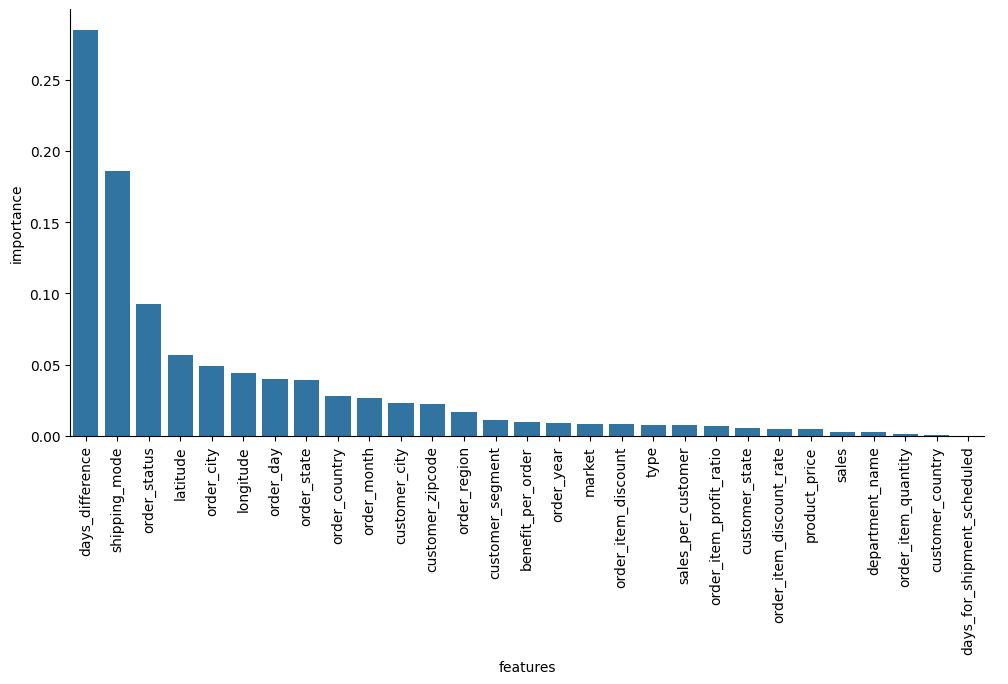

In [120]:
Check_Important_Feature(dt_clf[0],X_train)

In [ ]:
df_result = pd.DataFrame(result)

df_result.columns = ["Model", "Model_name", "Accuracy", "Recall", "F1_Score"]
df_result.drop([0],inplace=True)
df_result

####Best model selection



In [ ]:
df_result[df_result['Accuracy'] == df_result.Accuracy.max()]

*Inference*: We have selected decision tree classifier as the best fitted model to the given dataset with Accuracy score of 93%.